In [1]:
## Importing packages
library(tidyverse) # metapackage with lots of helpful functions
library(tidytext)
library(glmnet)
library(caret) # used to fit different models
library(doParallel) # enables paralell processing to speed up the process

## Data attached to this notebook
list.files(path = "../input")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-7

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘pac

[1] "customer-sentiment-from-reviews-bda-2023"

# 1. The project

**Where do the data come from? (To which population will results generalize?)**

Baby products reviews are part of a large crawl of product reviews from Amazon containing 82.83 million unique reviews from around 20 million users collected between May 1996 - July 2014. The results are likely to generalise to users of similar online marketplaces.

**What are candidate machine learning methods? (models? features?)**

Examples of the relevant ML methods are lasso regression, ridge regression, principal component analysis (PCA). Examples of the relevant features are token count, TF, IDF, TF-IDF, sentence length, negation words count, exclamation count, question mark count.

**What is the Bayes' error bound?**

Based on the last year results for this competition, the Bayes' error bound appears to be aroud 0.94 since it was the best accuracy achieved among last year groups.

# 2. Read Data

Locate and load the data into memory.

In [2]:
dir("../input", recursive=TRUE)

# Find the right file path
csv_filepath = dir("..", pattern="amazon_baby.csv", recursive=TRUE, full.names = TRUE)

# Read in the csv file
amazon = read_csv(csv_filepath) %>%
    rownames_to_column('id') 

head(amazon)

[1] "customer-sentiment-from-reviews-bda-2023/amazon_baby_testset_sample.csv"
[2] "customer-sentiment-from-reviews-bda-2023/amazon_baby.csv"

Rows: 183531 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): name, review
dbl (1): rating

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,name,review,rating
<chr>,<chr>,<chr>,<dbl>
1,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion not worth keeping. I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality. I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.",3
2,Planetwise Wipe Pouch,it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.,5
3,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt,NA
4,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"This is a product well worth the purchase. I have not found anything else like this, and it is a positive, ingenious approach to losing the binky. What I love most about this product is how much ownership my daughter has in getting rid of the binky. She is so proud of herself, and loves her little fairy. I love the artwork, the chart in the back, and the clever approach of this tool.",5
5,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love\'s Binky Fairy Puppet. It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!! You will save them soo many headaches.Thanks for this book! You all rock!!",NA
6,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"When the Binky Fairy came to our house, we didn\'t have any special gift and book to help explain to her about how important it is to stop using a pacifier. This book does a great job to help prepare your child for the loss of their favorite item. The doll is adorable and we made lots of cute movies with the Binky Fairy telling our daughter about what happens when the Binky Fairy comes. I would highly recommend this product for any parent trying to break the pacifier or thumb sucking habit.",5


The data frame contains both the train and test data. The test data are the reviews for which the rating is missing and we need to provide a prediction. The following logical index variable will be of help selecting the desired rows without the need to split the data frame into seperate sets.

In [3]:
trainidx = !is.na(amazon$rating)
table(trainidx)

trainidx
 FALSE   TRUE 
 30000 153531 

From the above, there are 153,531 training samples and 30,000 test samples.

# 3. Preprocessing

 Clearly the products differ on quality which will cause the ratings to differ, so we want to include product identiy as a predictive feature. Thus, we'll prepend the product name to the review text. 

In [4]:
amazon = amazon %>% 
    unite(review, name, review, sep = " — ", remove = FALSE) %>%
    mutate(rating = factor(ifelse(rating > 3, "True", "False"))) # make rating binary 

head(amazon)

id,review,name,rating
<chr>,<chr>,<chr>,<fct>
1,"Planetwise Flannel Wipes — These flannel wipes are OK, but in my opinion not worth keeping. I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality. I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.",Planetwise Flannel Wipes,False
2,Planetwise Wipe Pouch — it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.,Planetwise Wipe Pouch,True
3,Annas Dream Full Quilt with 2 Shams — Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt,Annas Dream Full Quilt with 2 Shams,NA
4,"Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book — This is a product well worth the purchase. I have not found anything else like this, and it is a positive, ingenious approach to losing the binky. What I love most about this product is how much ownership my daughter has in getting rid of the binky. She is so proud of herself, and loves her little fairy. I love the artwork, the chart in the back, and the clever approach of this tool.",Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,True
5,"Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book — All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love\'s Binky Fairy Puppet. It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!! You will save them soo many headaches.Thanks for this book! You all rock!!",Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,NA
6,"Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book — When the Binky Fairy came to our house, we didn\'t have any special gift and book to help explain to her about how important it is to stop using a pacifier. This book does a great job to help prepare your child for the loss of their favorite item. The doll is adorable and we made lots of cute movies with the Binky Fairy telling our daughter about what happens when the Binky Fairy comes. I would highly recommend this product for any parent trying to break the pacifier or thumb sucking habit.",Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,True


Creating a sample of 10 000 cases to test the code and than commenting it out.

In [5]:
set.seed(1)
sample <- amazon #%>% sample_n(5000)

## Tokenization

We're going to use tidytext to break up the text into separate tokens and count the number of occurences per review. As tokens we are going to consider single words and bi-grams. 

In [6]:
# single word tokenization
set.seed(1)

words <- sample %>%
  unnest_tokens(token, review, token = "words") %>% # unnest words from the review column
  count(id, name, rating, token) # count the number of words per observation

dim(words)
head(words, 5)

[1] 11511495        5

id,name,rating,token,n
<chr>,<chr>,<fct>,<chr>,<int>
1,Planetwise Flannel Wipes,False,12,1
1,Planetwise Flannel Wipes,False,6,1
1,Planetwise Flannel Wipes,False,8,1
1,Planetwise Flannel Wipes,False,a,2
1,Planetwise Flannel Wipes,False,about,1


In [7]:
# bigram tokenization
set.seed(1)

bigrams <- sample %>%
  unnest_tokens(token, review, token = "ngrams", n = 2) %>%
  count(id, name, rating, token) # count the number of bigrams per observation

dim(bigrams)
head(bigrams, 5)

[1] 15892066        5

id,name,rating,token,n
<chr>,<chr>,<fct>,<chr>,<int>
1,Planetwise Flannel Wipes,False,12 countwhich,1
1,Planetwise Flannel Wipes,False,6 pack,1
1,Planetwise Flannel Wipes,False,8 months,1
1,Planetwise Flannel Wipes,False,a nicer,1
1,Planetwise Flannel Wipes,False,a while,1



# 4. Features engineering

We are going to compute the following features:

- **token counts** (for unigrams and bigrams)

- **total number of words per review** (for unigrams and bigrams)

- **the $TFIDF_{d,t}$** (for unigrams and bigrams)

- **counts of exclamation and question marks per review**

- **negation counts per review** (for unigrams and bigrams)

## Token counts & total number of words per review

In [8]:
# total number of words per review
total_words <- words %>%
 group_by(name) %>%
 summarize(total = sum(n))

# combine token counts and total number of words per review 
review_words <- left_join(words, total_words)
head(review_words)

# transforming token counts into "id - feature - value" format          
token_counts <- review_words %>%
    mutate(feature = "token_counts") %>%
    select(id, feature = token, value = n) %>%
    distinct()
head(token_counts)

# transforming total number of words per review into "id - feature - value" format
total_num_words <- review_words %>%
    mutate(feature = "total_num_words") %>%
    select(id, feature, value = total) %>%
    distinct()
head(total_num_words)

Joining with `by = join_by(name)`


id,name,rating,token,n,total
<chr>,<chr>,<fct>,<chr>,<int>,<int>
1,Planetwise Flannel Wipes,False,12,1,84
1,Planetwise Flannel Wipes,False,6,1,84
1,Planetwise Flannel Wipes,False,8,1,84
1,Planetwise Flannel Wipes,False,a,2,84
1,Planetwise Flannel Wipes,False,about,1,84
1,Planetwise Flannel Wipes,False,also,1,84


id,feature,value
<chr>,<chr>,<int>
1,12,1
1,6,1
1,8,1
1,a,2
1,about,1
1,also,1


id,feature,value
<chr>,<chr>,<int>
1,total_num_words,84
10,total_num_words,920
100,total_num_words,37
1000,total_num_words,19249
10000,total_num_words,2113
100000,total_num_words,3608


## TF-IDF

**Non-zero variance features** for Unigrams

For binary and count data as considered here the variance is determined by the average. Hence, for the current data we can look simply at document frequencies and do not need to compute variances. 

We will remove tokens that occur in less than 0.01% of the documents (there are ~180,000 reviews in the data set; less than 0.01% &times; 180,000 reviews = 18 of the reviews).  

we can filter the rows in `features` for which $-\log(\text{df}_t / N) \leq -\log(0.01\%)$.

In [9]:
create_tfidf <- . %>%

    # Bind the TF-IDF columns
    bind_tf_idf(token, id, n) %>%

    # Replace NAs with 0
    replace_na(list(tf = 0, idf = Inf, tf_idf = 0)) %>%

    # Remove tokens that appear in more than 99.99% of reviews
    filter(idf <= -log(0.01 / 100)) %>%

    # Select only the columns we need
    select(id, feature = token, value = tf_idf )

### For Unigrams

In [10]:
words_tfidf <- create_tfidf(words)
dim(words_tfidf)
head(words_tfidf)

[1] 11290427        3

id,feature,value
<chr>,<chr>,<dbl>
1,12,0.045978984
1,6,0.030938856
1,8,0.040013073
1,a,0.008632354
1,about,0.023040804
1,also,0.022591531


### For Bigrams

In [11]:
bigrams_tfidf <- create_tfidf(bigrams)
dim(bigrams_tfidf)
head(bigrams_tfidf)

[1] 12431575        3

id,feature,value
<chr>,<chr>,<dbl>
1,6 pack,0.06150993
1,8 months,0.06099085
1,a nicer,0.09649717
1,a while,0.05405163
1,about 8,0.07926356
1,also ordered,0.09221965


## Exclamation & question marks

In [12]:
# tokenize and process the data
set.seed(1)
expr <- sample %>%
  unnest_tokens(token, review, token = "words", strip_punct = FALSE) %>%
  select(id, token, value = rating)

# exclamation marks in "id - feature - value" format
exclamations <- expr %>%
  filter(token == "!") %>%
  group_by(id) %>%
  count() %>%
  mutate(token = "!") %>%
  select(id, feature = token, value = n)
head(exclamations)

# question marks in "id - feature - value" format
questions <- expr %>%
  filter(token == "?") %>%
  group_by(id) %>%
  count() %>%
  mutate(token = "?") %>%
  select(id, feature = token, value = n)
head(questions)

id,feature,value
<chr>,<chr>,<int>
100,!,2
1000,!,1
10000,!,1
100001,!,2
10001,!,1
100020,!,1


id,feature,value
<chr>,<chr>,<int>
100076,?,1
100077,?,2
100082,?,1
100095,?,4
10010,?,1
100113,?,1


## Negation counts   
### For unigrams

In [13]:
# create a list of negation words
negation <-  tibble(word = c("not", "no", "never", "neither", "nor", "none", "nobody", "nowhere", "nothing", "no one", "non", "t")) # "t" stands for isn't, haven't, couldn't, etc.

# select only those rows of review_tf_idf that contain negation
negation_labeled <- inner_join(review_words, negation, by = c(token = "word"))

# negation counts perreview
negation_scores <- negation_labeled %>%
    select(id, n) %>%
    group_by(id) %>%
    summarise(neg_count = sum(n))
head(negation_scores, 3)

# transforming into "id - feature - value" format
neg_count <- review_words %>%
    select(id) %>%
    distinct()%>%
    left_join(negation_scores, by ="id") %>%
    mutate(neg_count = ifelse(is.na(neg_count), 0, neg_count), feature = "neg_count")  %>%
    select(id, feature, value = neg_count)
head(neg_count)

id,neg_count
<chr>,<int>
1,2
10,3
100,1


id,feature,value
<chr>,<chr>,<dbl>
1,neg_count,2
10,neg_count,3
100,neg_count,1
1000,neg_count,7
10000,neg_count,1
100000,neg_count,0


### For Bigrams

## Combining the data and creating a sparse matrix

In [14]:
# Combine features
features_df <-bind_rows(token_counts,
                        total_num_words,
                        words_tfidf,
                        bigrams_tfidf,
                        questions,
                        exclamations,
                        neg_count)

# Turn features into a sparse design matrix 
sparseM = features_df %>% 
    cast_sparse(id, feature, value)

# Verify the result:
sparseM[1:10,(ncol(sparseM)-5):ncol(sparseM)]


10 x 6 sparse Matrix of class "dgCMatrix"
       citrus i 3pack white pants 3pack ? ! neg_count
1             .           .           . . .         2
10            .           .           . . .         3
100           .           .           . . 2         1
1000          .           .           . . 1         7
10000         .           .           . . 1         1
100000        .           .           . . .         0
100001        .           .           . . 2         0
100002        .           .           . . .         1
100003        .           .           . . .         1
100004        .           .           . . .         1

## Correlated and linear combinations of features 

Although correlated (linear combinations of) features may exist, with thousands of features it's computationally too cumbersome to try to remove them directly. Instead we'll have to rely on the properties of the Lasso and Ridge regression to deal with them.



# 5. Models

## Model fitting

The aim of this competition is the predict the probability that a customer is ***satisfied***. This is deemed to be the case if `rating > 3`. 



Let's split design matrix and target into training and test portions.

In [15]:
# train indices
train_id <- sample %>%
    filter(!is.na(rating)) %>%
    select(id) %>%
    pull() # get id's and put them in a vector

# test indices
test_id <- sample %>%
    filter(is.na(rating)) %>%
    select(id) %>%
    pull()

# splitting design matrix
train <- sparseM[rownames(sparseM) %in% train_id, ]
test <-  sparseM[rownames(sparseM) %in% test_id, ]

In [16]:
# extracting y values for training set
target <- data.frame(id = rownames(train)) %>%
  inner_join(sample, by = "id") %>%
  pull(rating) 
unique(target)

[1] False True 
Levels: False True

### 1. Lasso regression 

In [17]:
# Use all available cores
cl <- makePSOCKcluster(detectCores())

# Register the cluster with doParallel
registerDoParallel(cl)

# Check registered cores to confirm it worked
getDoParWorkers()

[1] 4

Now, let's tune λ by cross-validation.

Warning message:
“from glmnet C++ code (error code -54); Convergence for 54th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”



Call:  cv.glmnet(x = train, y = target, lambda = grid, type.measure = "auc",      nfolds = 10, parallel = TRUE, family = "binomial", standardize = TRUE,      alpha = 1) 

Measure: AUC 

      Lambda Index Measure       SE Nonzero
min 0.002848    52  0.9424 0.000574    2026
1se 0.002848    52  0.9424 0.000574    2026

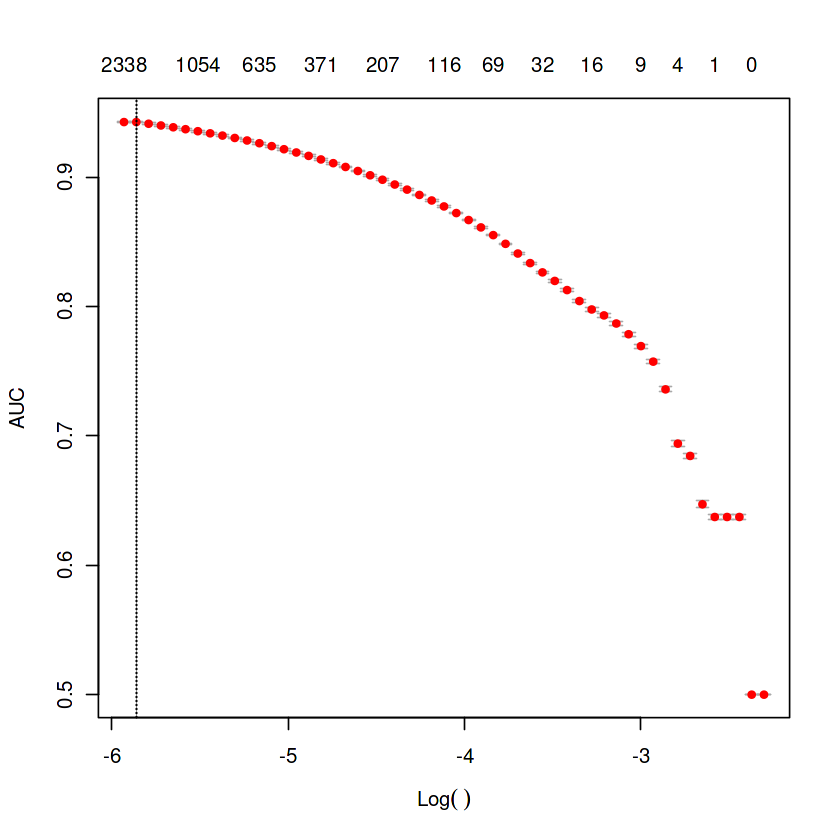

In [18]:
# Define lambda grid
grid <- 10^seq(-4, -1, length = 100)

# Fit the lasso model with cross-validation
lasso_reg_cv <- cv.glmnet(
  x = train,
  y = target,
  family = "binomial", # We predict two classes, so it's binomial
  standardize = TRUE, # Have to standardize for lasso and ridge
  parallel = TRUE, # Set to true to use multiple cpu cores
  type.measure = "auc", # Evaluate with Area Under the Curve
  nfold = 10, # Set to 10-fold cross validation
  alpha = 1, # Alpha = 1 for Lasso
  lambda = grid # Use the grid of lambda values
)

# Take a look at the results
lasso_reg_cv
plot(lasso_reg_cv)

We can now evaluate the performance at the cross-validated  λ.

### 2. Ridge regression 



Call:  cv.glmnet(x = train, y = target, lambda = grid, type.measure = "auc",      nfolds = 10, parallel = TRUE, family = "binomial", standardize = TRUE,      alpha = 0) 

Measure: AUC 

    Lambda Index Measure        SE Nonzero
min 0.5722    79  0.9483 0.0004963  184412
1se 0.7743    78  0.9481 0.0004860  184412

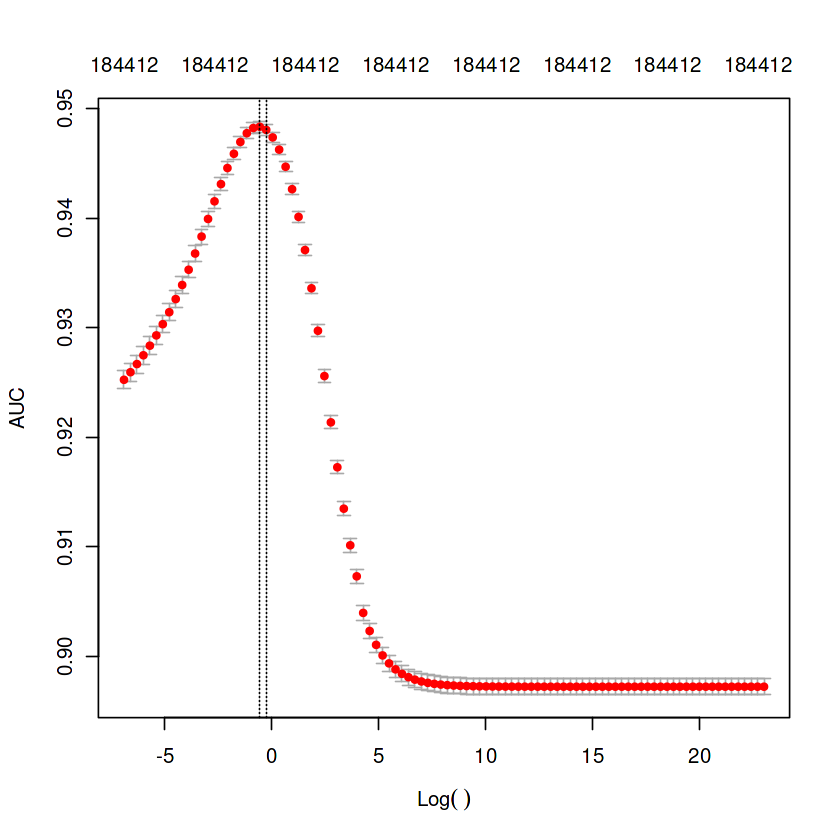

In [19]:
grid <- 10^seq(-3, 10, length = 100)

# Fit the ridge model with cross-validation
ridge_reg_cv <- cv.glmnet(
  x = train,
  y = target,
  family = "binomial", # We predict two classes, so it's binomial
  standardize = TRUE, # Have to standardize for lasso and ridge
  parallel = TRUE, # Set to true to use multiple cpu cores
  type.measure = "auc", # Evaluate with Area Under the Curve
  nfold = 10, # Set to 10-fold cross validation
  alpha = 0, # Alpha = 0 for Ridge
  lambda = grid # Use the grid of lambda values
)

# Take a look at the results
ridge_reg_cv
plot(ridge_reg_cv)

In [20]:
# lasso predictions 
lasso_pred  <- predict(lasso_reg_cv, 
                          train, 
                          s = "lambda.min", 
                          type = "class") %>% 
                          factor()

# ridge predictions
ridge_pred  <- predict(ridge_reg_cv, 
                          train, 
                          s = "lambda.min", 
                          type = "class") %>% 
                          factor()




### 3. Principal component analysis

PCA appears to be inapplicable in our case due to the problems with scaling. This is caused by the fact that all the values in some column are the same or equal to zero.

In [21]:
#features_df1 <- bind_rows(total_num_words,
#                        total_num_bigrams,
#                        words_tfidf,
#                        bigrams_tfidf,
#                        questions,
#                        exclamations,
#                        neg_count,
#                        neg_count_bigrams
#                        ) # some features were omitted due to problems with pivot wider

# pivot_wider the data frame with features
#features_df_wide <- features_df1 %>%
#     pivot_wider(names_from = "feature", 
#                 values_from = "value",
#                 values_fill = list(value = 0),# replace NAs with 0
#                 names_repair = "minimal") # to avoid problems naming conflicts caused by token_counts and review_tf_idf2 

# filter to include only rows where 'id' is in the training set (= the same number of rows as in 'y')
#features_df_wide <- features_df_wide[features_df_wide$id %in% rownames(train), ]

# de-select id
#features_df_wide = features_df_wide  %>% select(-id)

# perform PCA
#pca_model <- prcomp(features_df_wide, scale = TRUE) # unable to scale; scale = FALSE does not yield meaningful results
#summary(pca_model)$importance 

# scree plot for proportion of variance explained
#plot(summary(pca_model)$importance[2, 1:10], 
#      type = "o", 
#      ylab = "PVE", 
#      xlab = "Principal Component", 
#      main = "Scree plot for PCA")

# create a data frame for modeling
#model_data <- cbind(y, as.data.frame(pca_model$x))

# train a logistic regression model
#model <- glm(y ~ ., data = model_data, family = "binomial")



## Model evaluation



In this section we wull evaluate the model usingarious predictive performance measures, including AUC.

In [22]:
# performance evaluation
lasso_cm <- caret::confusionMatrix(lasso_pred, target)

# AUC
lasso_auc <- lasso_reg_cv$cvm %>% max()

# accuracy
lasso_accuracy <- (lasso_pred == target) %>% mean()

# sensitivity
lasso_sensitivity <- lasso_cm$byClass[["Sensitivity"]]

# specificity
lasso_specificity <- lasso_cm$byClass[["Specificity"]]


# performance evaluation
ridge_cm <- caret::confusionMatrix(ridge_pred, target)

# AUC
ridge_auc <- ridge_reg_cv$cvm %>% max()

# accuracy
ridge_accuracy <- (ridge_pred == target) %>% mean()

# sensitivity
ridge_sensitivity <- ridge_cm$byClass[["Sensitivity"]]

# specificity
ridge_specificity <- ridge_cm$byClass[["Specificity"]]

accuracy <- c(lasso_accuracy, ridge_accuracy)
sensitivity <- c(lasso_sensitivity, ridge_sensitivity)
specificity <- c(lasso_specificity, ridge_sensitivity)
auc <- c(lasso_auc, ridge_auc)
regression <- c("Lasso", "Ridge")
lasso_vs_ridge <- data.frame(regression, accuracy, sensitivity, specificity, auc)
lasso_vs_ridge

regression,accuracy,sensitivity,specificity,auc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Lasso,0.8971869,0.6581936,0.9709046,0.9424415
Ridge,0.9504204,0.7998232,0.7998232,0.9483476



# 6. Submitting your predictions


In [23]:
# prepare prediction for the testing set
lassopred  <- predict(lasso_reg_cv, 
                          test, 
                          s = "lambda.min", 
                          type = "response")


final <- tibble(Id =rownames(lassopred), 
                    Prediction = lassopred[,1]) %>%
         arrange(as.integer(Id)) 

head(final)
dim(final)

Id,Prediction
<chr>,<dbl>
3,0.9585770
5,0.9692157
8,0.9264010
14,0.8387249
20,0.9124983
22,0.2608595


[1] 30000     2

In [24]:
# write your predictions data frame to file
write_csv(final, file="predictions.csv")

# 7. Member Contribution

All members worked on feature functions:

- Alex = Negations, IT-IDF, Token Count
- Jakov = Sentence Length
- Joselyn = Exclamations & Questions

Jakob worked on the model on his own and we all cleaned up the notebook together.